# SFM in Python

## libraries

In [1]:
# SURF and SIFT is only supported in older version
# pip install opencv-contrib-python==3.4.2.16
# pip install opencv-python==3.4.2.16
import numpy as np
import glob,os,sys
import cv2 as cv 
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import json
import pickle
from scipy.sparse import lil_matrix
import time
from scipy.optimize import least_squares
from scipy.spatial.transform import Rotation as R
import numpy.matlib
import seaborn as sns
from collections import Counter

In [2]:
print(cv.__version__)

3.4.2


## functions

In [3]:
# SURF and SIFT is only supported in older version
# pip install opencv-contrib-python==3.4.2.17
# pip install opencv-python==3.4.2.17
import numpy as np
import glob,os,sys
import cv2 as cv 
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import json
import pickle
from scipy.sparse import lil_matrix
import time
from scipy.optimize import least_squares
from scipy.spatial.transform import Rotation as R
import numpy.matlib
import seaborn as sns


def read_image(path,K,distcoeffs,undistort=True,ratio=1):
    '''
    load images as gray images
    '''
    img=cv.imread(path,0)
    if(undistort):
        img=cv.undistort(img,K,distcoeffs)
    return img
#     dim=(int(img.shape[1]*ratio),int(img.shape[0]*ratio))
#     resized=cv.resize(img,dim)
#     return resized


def linearTriangulation(P1,x1s,P2,x2s,K):
    '''
    Given two projection matrice and calibrated image points, triangulate them to get 3-D points
    Input:
        P1:     4 x 4
        P2:     4 x 4
        x1s:    N x 3
        x2s:    N x 3
        K:      3 x 3 
    return:
        XS:     4 x N
        error:  N x 4
    '''
    XS=np.zeros((4,x1s.shape[0]))
    err=np.zeros((1,x1s.shape[0]))
    for k in range(x1s.shape[0]):
        r1=x1s[k,0]*P1[2,:]-P1[0,:]
        r2=x1s[k,1]*P1[2,:]-P1[1,:]
        r3=x2s[k,0]*P2[2,:]-P2[0,:]
        r4=x2s[k,1]*P2[2,:]-P2[1,:]
        
        A=np.vstack((r1,r2,r3,r4))
        U,S,Vh=np.linalg.svd(A)
        XS[:,k]=Vh.T[:,-1]/Vh.T[3,3]
    
    # get the reprojection errors
    reprojected=np.dot(P1,XS)[:3,:].T
    reprojected=reprojected[:,:2]/reprojected[:,2,np.newaxis]
    error_1=reprojected-x1s[:,:2]
    error_1=np.dot(K[:2,:2],error_1.T).T
    
    reprojected=np.dot(P2,XS)[:3,:].T
    reprojected=reprojected[:,:2]/reprojected[:,2,np.newaxis]
    error_2=reprojected-x2s[:,:2]
    error_2=np.dot(K[:2,:2],error_2.T).T
    
    error=np.hstack((error_1,error_2))
    return XS,error


def decomposeE(E,x1s,x2s,K):
    '''
    Given the essential and calibrated image points, get the second projection matrix and the index of inliers
    Input:
        E:      3 x 3
        x1s:    N x 3
        x2s:    N x 3
        K:      3 x 3

    Return:
        proj_mat:   4 x 4 
        ind_inlier: N x 1
    '''
    W=np.array([[0,-1,0],[1,0,0],[0,0,1]])
    [U,S,Vh]=np.linalg.svd(E) # U and Vh is normalized
    
    # extract translation
    t=U[:,2].reshape((-1,1))
    
    # extraction rotation
    R1=np.dot(np.dot(U,W),Vh)
    R2=np.dot(np.dot(U,W.T),Vh)
    if(np.linalg.det(R1)<0):
        R1=-R1
    if(np.linalg.det(R2)<0):
        R2=-R2
    
    # four possible projection matrice
    P1=np.vstack((np.hstack((R1,t)),np.array([0,0,0,1])))
    P2=np.vstack((np.hstack((R1,-t)),np.array([0,0,0,1])))
    P3=np.vstack((np.hstack((R2,t)),np.array([0,0,0,1])))
    P4=np.vstack((np.hstack((R2,-t)),np.array([0,0,0,1])))
    Ps=[P1,P2,P3,P4]
    
    # determine the projection matrix by the maximum inliers
    n_inliers=[]
    ind_inliers=[]
    P=np.eye(4) # the first projection is identical
    for proj_mat in Ps:
        X,_=linearTriangulation(P,x1s,proj_mat,x2s,K)
        p1X=X
        p2X=np.dot(proj_mat,X)
        
        n_infront1=(p1X[2,:]>0).sum()
        n_infront2=(p2X[2,:]>0).sum()
        
        ind_valid=np.logical_and(p1X[2,:]>0,p2X[2,:]>0)
        ind_inliers.append(ind_valid)
        n_inliers.append(ind_valid.sum())
    
    # determine the best projection matrix by the most reconstructed points in front of the cameras
    n_inliers=np.array(n_inliers)
    ind_proj=n_inliers.argmax() 
    
    ind_inlier=ind_inliers[ind_proj]
    proj_mat=Ps[ind_proj]
    return proj_mat,ind_inlier

def proj_matrix_to_camera_vector(proj_mat):
    '''
    decompose the projection matrix to camera paras(rotation vector and translation vector)
    Input: 
        proj_mat:       4 x 4
    Return: 
        camera_vec:     1 x 6
    
    '''
    rot_mat=proj_mat[:3,:3]
    r=R.from_dcm(rot_mat)
    rot_vec=r.as_rotvec()
    t=proj_mat[:3,3]
    camera_vec=np.hstack((rot_vec,t))
    return camera_vec

def recover_projection_matrix(camera_param):
    '''
    given camera parameters, recover the projection matrix
    Input:
        camera_param:   1 x 6
    Return: 
        P:              4 x 4
        
    '''
    rot_vec=camera_param[:3]
    translate_vec=camera_param[3:]
    r=R.from_rotvec(rot_vec)
    rot_matrix=r.as_dcm()
    P=np.eye(4)
    P[:3,:3]=rot_matrix
    P[:3,3]=translate_vec.T
    return P

def rotate(points, rot_vecs):
    '''
    Rotate points by given rotation vectors, Rodrigues' rotation formula is used.
    Input: 
        points:     
        rot_vecs:
    Return: 
        rotated points
    '''
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

def project(points, camera_params):
    '''
    Convert 3-D points to 2-D by projecting onto images.
    '''
    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj=points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    return points_proj

def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d, K):
    '''
    get residuals
    '''
    # recover cameras params and points 3d
    camera_params=params[:n_cameras*6].reshape((n_cameras,6))
    points_3d=params[n_cameras*6:].reshape((n_points,3))
    
    # reproject 3d points
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    residual=points_proj-points_2d
    residual=np.dot(K[:2,:2],residual.T).T
    return residual.ravel()



def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    '''
    build sparse jacobian
    '''
    m = camera_indices.size * 2
    n = n_cameras * 6 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(6):
        A[2 * i, camera_indices * 6 + s] = 1
        A[2 * i + 1, camera_indices * 6 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 6 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 6 + point_indices * 3 + s] = 1

    return A

In [29]:
class SFM_Params:
    def __init__(self,img_dir=None,threshold=0.75,hessianThreshold=800,detector='SIFT',matcher='FLANN'):
        self.img_dir=img_dir
        files=sorted(glob.glob(self.img_dir))
        self.files=files
        self.n_cameras=len(self.files) # number of cameras
        self.n_good_matches=np.zeros((self.n_cameras,self.n_cameras))  # number of good matches between each camera
        self.threshold=threshold  # ratio test threshold
        
        # feature detectors
        sift = cv.xfeatures2d.SIFT_create(nOctaveLayers=4)
        surf = cv.xfeatures2d.SURF_create(hessianThreshold=hessianThreshold,extended=True)   # surf detector
        if(detector=='SIFT'):
            self.detector=sift
        elif(detector=='SURF'):
            self.detector=surf

        # feature matcher
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE)
        search_params = dict(checks=100)   # or pass empty dictionary
        flann = cv.FlannBasedMatcher(index_params,search_params)
        bf = cv.BFMatcher()  # Brute Force knn matcher

        if(matcher=='FLANN'):
            self.matcher=flann
        elif(matcher=='BF'):
            self.matcher=bf

## load data 

In [30]:
###############################################
# set the camera intrinsics and configurations
###############################################
fx,fy=4.7470e3, 4.7417e3
k1,k2=-0.0780,0.1828
dx,dy=2.9752e3,1.9776e3
K=np.array([[fx,0,dx],[0,fy,dy],[0,0,1]])
print(K)
FOCAL_LENGTH=(fx+fy)/2
DISTCOEFFS=np.array([k1,k2,0,0])

THRESHOLD=0.7
HESSIANTHRESHOLD=1000
DETECTOR='SIFT'
MATCHER='FLANN'
CAMERA_INTRINCICS=[fx,fy,k1,k2]

############################################
# load images, detect and match features
############################################
DIR_IMAGES='Images/easyones/*.jpg'
config=SFM_Params(DIR_IMAGES,hessianThreshold=HESSIANTHRESHOLD,detector=DETECTOR,threshold=THRESHOLD,matcher=MATCHER)
config.post_threshold=10
config.pre_threshold=64
config.dist_threshold=500
dict_cameras={}
n_cameras=config.n_cameras
for i in range(n_cameras):
    dict_cameras[i]={}

# load images
for i in range(n_cameras):
    img_path=config.files[i]
    img=read_image(img_path,K,DISTCOEFFS,undistort=False)
    dict_cameras[i]['img']=img
print('Loaded in total %d frames ' % n_cameras)

# get features
t0=time.time()
for i in range(n_cameras):
    img=dict_cameras[i]['img']
    kp, des = config.detector.detectAndCompute(img,None)
    dict_cameras[i]['kp'],dict_cameras[i]['des']=kp,des
t1=time.time()
print('Feature detection takes %d seconds' % (t1-t0))

# get feature matches
t0=time.time()
for i in range(n_cameras):
    dict_cameras[i]['matches']=[] # matches is a list
    des1=dict_cameras[i]['des']  # descriptors of the first camera, queryIdx
    for j in range(n_cameras):
        if(i!=j):
            des2=dict_cameras[j]['des']  # des1——query index; des2 —— train index
            matches = config.matcher.knnMatch(des1,des2,k=2)# find the best and second best match
            matches=sorted(matches,key=lambda x:x[0].distance) # sort by the distance first, ascending order
            good_match = []
            ind_train=[] # filter the cases when multiple queryIdx point to the same trainIdx
            for m,n in matches:
                if m.distance < config.threshold*n.distance and m.trainIdx not in ind_train:
                    good_match.append(m)
                    ind_train.append(m.trainIdx)
            config.n_good_matches[i,j]=len(good_match)
            dict_cameras[i]['matches'].append(good_match)
        else:
            dict_cameras[i]['matches'].append([])
t1=time.time()
print('Feature matching takes %d seconds' % (t1-t0))

[[4.7470e+03 0.0000e+00 2.9752e+03]
 [0.0000e+00 4.7417e+03 1.9776e+03]
 [0.0000e+00 0.0000e+00 1.0000e+00]]
Loaded in total 14 frames 
Feature detection takes 45 seconds
Feature matching takes 165 seconds


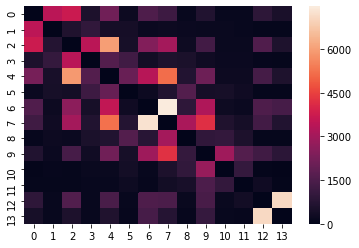

In [31]:
ax = sns.heatmap(config.n_good_matches)

## Init two images

In [32]:
for i in range(config.n_cameras):
    dict_cameras[i]['camera']=None
    dict_cameras[i]['point_indice']=None
    dict_cameras[i]['registered_2d_indice']=None
config.indice_registered_cameras=[]
config.reconstructed_points_3d=None

`ftol` termination condition is satisfied.
Function evaluations 127, initial cost 1.0845e+05, final cost 8.5017e+02, first-order optimality 1.10e+02.
Use camera 6 and camera 7 to initialize, 7472 pairs used, 6287 pairs reconstructed 


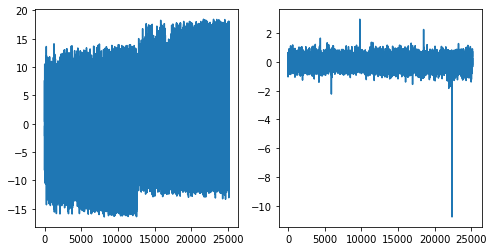

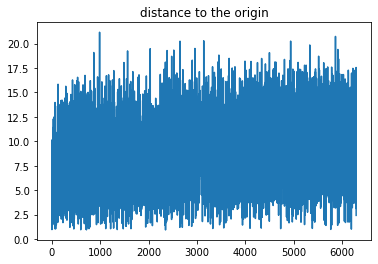

In [33]:
############################################################
# determine initial pair
############################################################

ind = np.unravel_index(np.argmax(config.n_good_matches, axis=None), config.n_good_matches.shape)
# set current match
ind_img1=ind[0]
ind_img2=ind[1]

# tag=0
# for i in range(config.n_cameras):
#     for j in range(config.n_cameras):
#         if(i!=j):
#             c_match=dict_cameras[i]['matches'][j]

#             # recover 2D pts
#             pts1,pts2=[],[]
#             for ele in c_match:
#                 pts1.append(dict_cameras[i]['kp'][ele.queryIdx].pt)
#                 pts2.append(dict_cameras[j]['kp'][ele.trainIdx].pt)    
#             pts1=np.int32(pts1)
#             pts2=np.int32(pts2)

#             # compute F
#             ii_F, ii_mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC,1,0.99999)
#             if(ii_mask.ravel().sum()>tag):
#                 tag=ii_mask.ravel().sum()
#                 ind_img1,ind_img2=i,j

c_match=dict_cameras[ind_img1]['matches'][ind_img2]
# recover 2D pts
pts1,pts2=[],[]
for ele in c_match:
    pts1.append(dict_cameras[ind_img1]['kp'][ele.queryIdx].pt)
    pts2.append(dict_cameras[ind_img2]['kp'][ele.trainIdx].pt)    
pts1=np.int32(pts1)
pts2=np.int32(pts2)
n_points_2d=pts1.shape[0]

# compute F
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC,2,0.99999)


# filter the outliers 
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# calibrate the homogeneous points
if(pts1.shape[1]==2):
    pts1=np.hstack((pts1,np.ones((pts1.shape[0],1))))
if(pts2.shape[1]==2):
    pts2=np.hstack((pts2,np.ones((pts2.shape[0],1))))
img1_calibrated_inliers=np.dot(np.linalg.inv(K),pts1.T).T
img2_calibrated_inliers=np.dot(np.linalg.inv(K),pts2.T).T

# get Essential matrix from calibration matrix and fundamental matrix
E=np.dot(np.dot(K.T,F),K)

projection_matrix, ind_inliers=decomposeE(E,img1_calibrated_inliers,img2_calibrated_inliers,K)


#############################################################
# bundle adjustment
#############################################################
P1=np.eye(4)
P2=projection_matrix
inliers1=img1_calibrated_inliers[ind_inliers]
inliers2=img2_calibrated_inliers[ind_inliers]
XS,error=linearTriangulation(P1,inliers1,P2,inliers2,K)

n_cameras=2
n_points=XS.shape[1]

# get camera params,  n_cameras x 6
camera_params=np.zeros((n_cameras,6))
camera_params[0,:]=proj_matrix_to_camera_vector(P1)
camera_params[1,:]=proj_matrix_to_camera_vector(P2)

# points_3d, n_points x 3
points_3d=XS[:3,:].T

# get camera_indice
camera_indices=[]
for i in range(n_cameras):
    camera_indices.extend([i]*n_points)
camera_indices=np.array(camera_indices)

# get point_indice
point_indices=[]
for i in range(n_cameras):
    for j in range(n_points):
        point_indices.append(j)
point_indices=np.array(point_indices)

# get point_2d
points_2d_1=inliers1[:,:2]
points_2d_2=inliers2[:,:2]
points_2d=np.vstack((points_2d_1,points_2d_2))

# get params
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d,K)
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(f0)

# optimize
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
res = least_squares(fun, x0,jac='3-point',jac_sparsity=A, verbose=1, x_scale='jac', ftol=1e-6, 
                    method='trf',loss='soft_l1',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d,K))
plt.subplot(122)
plt.plot(res.fun)

#########################################
# update the parameters
#########################################
config.indice_registered_cameras.append(ind_img1)
config.indice_registered_cameras.append(ind_img2)

# update the optimized parameters
optimized_params=res.x
camera_params=optimized_params[:n_cameras*6].reshape((n_cameras,6))
points_3d=optimized_params[n_cameras*6:].reshape((n_points,3))

# initial query and train indice
query_indice=[ele.queryIdx for ele in c_match] # img1
train_indice=[ele.trainIdx for ele in c_match] # img2

# filter by ransacFundamental and decomposeE
query_indice=np.array(query_indice)
train_indice=np.array(train_indice)

mask_F=mask.ravel()==1
mask_E=ind_inliers
query_indice=query_indice[mask_F][mask_E]
train_indice=train_indice[mask_F][mask_E]

# filter observations with big reprojection error
ff=np.abs(res.fun.reshape((-1,2)))
ii_inlier=(ff<config.post_threshold).sum(1)==2
mask_query=ii_inlier[:query_indice.shape[0]]
mask_train=ii_inlier[query_indice.shape[0]:]
mask=np.logical_and(mask_query,mask_train)
query_indice=query_indice[mask] 
train_indice=train_indice[mask]
config.reconstructed_points_3d=points_3d[mask]

# filter outlier by distance to the origin
ORIGIN=np.mean(config.reconstructed_points_3d,0)
distance=np.linalg.norm(config.reconstructed_points_3d-ORIGIN,axis=1)
ii_inlier=distance<config.dist_threshold
query_indice=query_indice[ii_inlier]
train_indice=train_indice[ii_inlier]
config.reconstructed_points_3d=config.reconstructed_points_3d[ii_inlier]
print('Use camera %d and camera %d to initialize, %d pairs used, %d pairs reconstructed ' 
    % (ind_img1,ind_img2,n_points_2d,ii_inlier.sum()))

# update the camera dictionary
dict_cameras[ind_img1]['camera']=camera_params[0]
dict_cameras[ind_img1]['indice_registered_2d']=query_indice # indice of the reconstructed 2d points
dict_cameras[ind_img1]['point_indice']=np.arange(len(query_indice)) # indice mapping to the 3D points
dict_cameras[ind_img2]['camera']=camera_params[1]
dict_cameras[ind_img2]['indice_registered_2d']=train_indice
dict_cameras[ind_img2]['point_indice']=np.arange(len(train_indice))

plt.figure()
plt.plot(np.linalg.norm(config.reconstructed_points_3d-ORIGIN,axis=1))
plt.title('distance to the origin')

# save the initial results
np.savetxt('results/2.txt',config.reconstructed_points_3d,delimiter=';')

## register more cameras

--------------------------------------------------------------------------------
Registering the 3th camera.....................................................
Use 364 points to register camera 9 by camera 12
Get 244 inliers after PnPRansac


KeyboardInterrupt: 

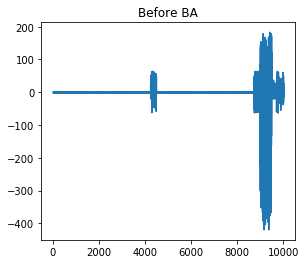

In [19]:
for i in range(config.n_cameras-2): # loop through all the left cameras
    plt.figure(figsize=(10,4))
    #########################################################
    # determine the next camera to be registered and linked
    #########################################################
    max_overlapping=0
    index_camera_3d=0 # camera used to provide 3d points
    index_camera_2d=0 # camera  used to provide 2d points
    for j in config.indice_registered_cameras:   # find the registered cameras with the maximum overlap points
        crn_matches=dict_cameras[j]['matches'] # current matches with all the other cameras 
        indice_query_registered=dict_cameras[j]['indice_registered_2d'] # indice of reconstructed points
        for ii in range(config.n_cameras):
            if(ii not in config.indice_registered_cameras): # only inspect non-registered cameras
                crn_match=crn_matches[ii]
                indice_overlap=[ele for ele in crn_match if ele.queryIdx in indice_query_registered]
                n_overlap=len(indice_overlap)
                # update the maximum overlap
                if(n_overlap>max_overlapping):
                    max_overlapping=n_overlap
                    index_camera_3d=j
                    index_camera_2d=ii
    print('--------------------------------------------------------------------------------')
    print('Registering the %dth camera.....................................................' % (i+3))
    print('Use %d points to register camera %d by camera %d' % (max_overlapping,index_camera_2d,index_camera_3d))
    
    
    ######################################################### 
    # ransacPnP
    #########################################################
    crn_match=dict_cameras[index_camera_3d]['matches'][index_camera_2d] # match from 3D to 2D
    camera_3d=dict_cameras[index_camera_3d]  
    camera_2d=dict_cameras[index_camera_2d]
    
    # get 2D and 3D points
    indice_points_2d,indice_points_3d=[],[]
    new_points_2d=[]
    for ele in crn_match:
        check_exist=np.where(camera_3d['indice_registered_2d']==ele.queryIdx)[0]
        if(len(check_exist)!=0):
            assert len(check_exist)==1
            indice_points_2d.append(ele.trainIdx)
            new_points_2d.append(camera_2d['kp'][ele.trainIdx].pt)
        
            ind_3d=check_exist[0]
            indice_points_3d.append(camera_3d['point_indice'][ind_3d])
            
    new_points_2d=np.float64(new_points_2d)   
    existing_points_3d=config.reconstructed_points_3d[indice_points_3d]
    
    assert existing_points_3d.shape[0]==new_points_2d.shape[0]
    # set reprojection error threshold
    _,rvec,tvec,ind_inliers=cv.solvePnPRansac(objectPoints = existing_points_3d, imagePoints = new_points_2d, 
                                              cameraMatrix = K, distCoeffs = None,reprojectionError=12)
    new_camera_params=np.hstack((rvec.flatten(),tvec.flatten()))
    new_proj_matrix=recover_projection_matrix(new_camera_params)
    
    # filter the outliers from PnP
    indice_points_2d=np.array(indice_points_2d)[ind_inliers]
    indice_points_3d=np.array(indice_points_3d)[ind_inliers]
    
    print('Get %d inliers after PnPRansac' % (len(ind_inliers)))
    
    # update the parameters of new camera
    dict_cameras[index_camera_2d]['camera']=new_camera_params
    dict_cameras[index_camera_2d]['indice_registered_2d']=indice_points_2d.flatten()
    dict_cameras[index_camera_2d]['point_indice']=indice_points_3d.flatten()
    
    ##############################################################
    # reconstruct 2D points with all the other images
    # -----------------------------------------------
    # 1. if ele.queryIdx in dict_cameras[j]['indice_registered_2d']
    #    then it has been linked to a 3D point
    # 2. if ele.queryIdx not in ... and ele.trainIdx not in
    #    then reconstruct a new 3D points
    # 3. if ele.queryIdx not in ... but ele.trainIdx in 
    #    then it should be linked to that 3D point, and this point 
    #    could be the 3D-2D one, or the new one, which is in case 2
    ##############################################################
    P1=new_proj_matrix
    for j in config.indice_registered_cameras:
        # use registered cameras as queryIdx
        crn_match=dict_cameras[j]['matches'][index_camera_2d]
        P2=recover_projection_matrix(dict_cameras[j]['camera'])
        
        pts1,pts2=[],[] # indice_1 => 2d camera 
        indice_1,indice_2=[],[]
        ii_2d_indice,ii_point_indice=[],[] # used for case 3
        jj_2d_indice,jj_point_indice=[],[] # used for case 1
        for ele in crn_match:
            if(ele.queryIdx not in dict_cameras[j]['indice_registered_2d']):
                # case 2, reconstruct new one
                check_exist=np.where(dict_cameras[index_camera_2d]['indice_registered_2d']==ele.trainIdx)[0]
                if(len(check_exist)==0):
                    pts1.append(dict_cameras[index_camera_2d]['kp'][ele.trainIdx].pt)
                    pts2.append(dict_cameras[j]['kp'][ele.queryIdx].pt)
                    indice_1.append(ele.trainIdx)
                    indice_2.append(ele.queryIdx)
                # case 3, link the observation
                else:
                    crn_point_index=dict_cameras[index_camera_2d]['point_indice'][check_exist[0]]                    
                    ii_2d_indice.append(ele.queryIdx)
                    ii_point_indice.append(crn_point_index)
            else:
                # case 1, link the observation
                check_exist=np.where(dict_cameras[index_camera_2d]['indice_registered_2d']==ele.trainIdx)[0]
                if(len(check_exist)==0):
                    jj_2d_indice.append(ele.trainIdx)
                    check_exist=np.where(dict_cameras[j]['indice_registered_2d']==ele.queryIdx)[0][0]
                    crn_point_index=dict_cameras[j]['point_indice'][check_exist]
                    jj_point_indice.append(crn_point_index)        
            
                    
        #####################################################################
        # filter outliers before BA by distance to the origin of the newly
        # reconstructed 3D points and the 2D reprojection error
        ####################################################################
        if(len(pts1)!=0 and len(pts2)!=0):
            pts1=np.float64(pts1)
            pts2=np.float64(pts2)
            indice_1=np.array(indice_1)
            indice_2=np.array(indice_2)

            # calibrate the homogeneous points and reconstruct them
            if(pts1.shape[1]==2):
                pts1=np.hstack((pts1,np.ones((pts1.shape[0],1))))
            if(pts2.shape[1]==2):
                pts2=np.hstack((pts2,np.ones((pts2.shape[0],1))))
            
            pts1=np.dot(np.linalg.inv(K),pts1.T).T
            pts2=np.dot(np.linalg.inv(K),pts2.T).T
            XS,error=linearTriangulation(P1,pts1,P2,pts2,K)
            
            # filter newly reconstructed outliers by reprojection error and the distance to the origin
            ii_inlier=(np.abs(error)<config.pre_threshold).sum(1)==4
            jj_inlier=np.linalg.norm(XS.T[:,:3]-ORIGIN,axis=1)<config.dist_threshold
            mask=np.logical_and(ii_inlier,jj_inlier)
            XS=XS[:,mask]
            indice_1=indice_1[mask]
            indice_2=indice_2[mask]
            
            # filter newly linked observations with big reprojection errors 
            if(len(ii_point_indice)!=0):
                points_3d=config.reconstructed_points_3d[ii_point_indice]
                points_3d=np.hstack((points_3d,np.ones((points_3d.shape[0],1))))
                proj_mat=recover_projection_matrix(dict_cameras[j]['camera'])
                projected_2d=np.dot(proj_mat,points_3d.T).T[:,:3]
                projected_2d=projected_2d[:,:2]/projected_2d[:,2,np.newaxis]

                points_2d=[dict_cameras[j]['kp'][ele].pt for ele in ii_2d_indice]
                points_2d=np.float64(points_2d)
                points_2d=np.hstack((points_2d,np.ones((points_2d.shape[0],1))))
                points_2d=np.dot(np.linalg.inv(K),points_2d.T).T[:,:2]

                error=np.dot(K[:2,:2],(projected_2d-points_2d).T).T
                mask=(np.abs(error)<config.pre_threshold).sum(1)==2
                ii_point_indice=np.array(ii_point_indice)[mask]
                ii_2d_indice=np.array(ii_2d_indice)[mask]

            if(len(jj_2d_indice)!=0):
                points_3d=config.reconstructed_points_3d[jj_point_indice]
                points_3d=np.hstack((points_3d,np.ones((points_3d.shape[0],1))))
                proj_mat=recover_projection_matrix(dict_cameras[index_camera_2d]['camera'])
                projected_2d=np.dot(proj_mat,points_3d.T).T[:,:3]
                projected_2d=projected_2d[:,:2]/projected_2d[:,2,np.newaxis]

                points_2d=[dict_cameras[index_camera_2d]['kp'][ele].pt for ele in jj_2d_indice]
                points_2d=np.float64(points_2d)
                points_2d=np.hstack((points_2d,np.ones((points_2d.shape[0],1))))
                points_2d=np.dot(np.linalg.inv(K),points_2d.T).T[:,:2]

                error=np.dot(K[:2,:2],(projected_2d-points_2d).T).T
                mask=(np.abs(error)<config.pre_threshold).sum(1)==2
                jj_point_indice=np.array(jj_point_indice)[mask]
                jj_2d_indice=np.array(jj_2d_indice)[mask]
            
            
            # update reconstructed 3D points
            new_points_3d=XS[:3,:].T
            n_new_points_3d=new_points_3d.shape[0]
            n_exist_pts_3d=config.reconstructed_points_3d.shape[0]
            new_point_indice=np.arange(n_exist_pts_3d,n_exist_pts_3d+n_new_points_3d)
            tmp=config.reconstructed_points_3d
            config.reconstructed_points_3d=np.vstack((tmp,new_points_3d))
            
            # update the camera ind_2d
            tmp=dict_cameras[index_camera_2d]['indice_registered_2d']
            dict_cameras[index_camera_2d]['indice_registered_2d']=np.hstack((tmp,indice_1))
            tmp=dict_cameras[index_camera_2d]['point_indice']
            dict_cameras[index_camera_2d]['point_indice']=np.hstack((tmp,new_point_indice))

            if(len(jj_2d_indice)!=0):
                tmp=dict_cameras[index_camera_2d]['point_indice']
                dict_cameras[index_camera_2d]['point_indice']=np.hstack((tmp,jj_point_indice))
                tmp=dict_cameras[index_camera_2d]['indice_registered_2d']
                dict_cameras[index_camera_2d]['indice_registered_2d']=np.hstack((tmp,jj_2d_indice))
            
            # update camera j
            tmp=dict_cameras[j]['indice_registered_2d']
            dict_cameras[j]['indice_registered_2d']=np.hstack((tmp,indice_2))
            tmp=dict_cameras[j]['point_indice']
            dict_cameras[j]['point_indice']=np.hstack((tmp,new_point_indice))
            
            if(len(ii_2d_indice)!=0):
                tmp=dict_cameras[j]['point_indice']
                dict_cameras[j]['point_indice']=np.hstack((tmp,ii_point_indice))
                tmp=dict_cameras[j]['indice_registered_2d']
                dict_cameras[j]['indice_registered_2d']=np.hstack((tmp,ii_2d_indice))
            
    ######################################################
    # run BA
    ######################################################
    config.indice_registered_cameras.append(index_camera_2d)
    n_cameras=len(config.indice_registered_cameras)
    n_points=config.reconstructed_points_3d.shape[0]
    
    
    # points_3d, n_points x 3
    points_3d=config.reconstructed_points_3d
    
    # get camera params,points_2d, camera_indice
    camera_params=np.zeros((n_cameras,6))
    camera_indices=[]
    point_indices=[]
    points_2d=[]
    for j in range(n_cameras):
        crn_camera_index=config.indice_registered_cameras[j]
        
        camera_params[j,:]=dict_cameras[crn_camera_index]['camera']
        camera_indices.extend([j]*dict_cameras[crn_camera_index]['indice_registered_2d'].shape[0])
        point_indices.extend(dict_cameras[crn_camera_index]['point_indice'].tolist())
        
        for ele in dict_cameras[crn_camera_index]['indice_registered_2d']:
            points_2d.append(dict_cameras[crn_camera_index]['kp'][ele].pt)
            
    points_2d=np.float64(points_2d)
    camera_indices=np.array(camera_indices)  
    point_indices=np.array(point_indices)  
    
    # calibrate the 2d image pts to calculate residual
    if(points_2d.shape[1]==2):
        points_2d=np.hstack((points_2d,np.ones((points_2d.shape[0],1))))
    points_2d=np.dot(np.linalg.inv(K),points_2d.T).T
    points_2d=points_2d[:,:2]
    
    # get params
    x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
    f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d,K)
    plt.subplot(121)
    plt.plot(f0)
    plt.title('Before BA')

    # optimize
    A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
    res = least_squares(fun, x0,jac='3-point',jac_sparsity=A, verbose=1, x_scale='jac', ftol=1e-5, method='trf',loss='soft_l1',
                        args=(n_cameras, n_points, camera_indices, point_indices, points_2d,K))
    plt.subplot(122) 
    
    ###################################################################################
    # filter the big outliers and distant 3D points by updateing the camera dictionary
    ###################################################################################
    optimized_params=res.x   
    camera_params=optimized_params[:n_cameras*6].reshape((n_cameras,6))
    points_3d=optimized_params[n_cameras*6:].reshape((n_points,3))
    
    # filter by reprojection error
    ff=np.abs(res.fun.reshape((-1,2)))
    ii_inlier=(ff<config.post_threshold).sum(1)==2
    
    # filter by the distance to the origin
    pts_3d=points_3d[point_indices]
    jj_inlier=np.linalg.norm(pts_3d-ORIGIN,axis=1)<config.dist_threshold
    
    mask=np.logical_and(ii_inlier,jj_inlier)
    
    # filter if there's only 1 support
    left_point_indices=point_indices[mask]
    count_support=dict(Counter(left_point_indices.tolist()))
    remove_indice=[]
    for key,value in count_support.items():
        if(value==1):
            remove_indice.append(key)
    ii_mask=[True if ele not in remove_indice else False for ele in point_indices]
    mask=np.logical_and(mask,ii_mask)
            
    # plot new residuals
    ii_mask=numpy.matlib.repmat(mask,2,1)
    ii_mask=np.reshape(ii_mask,(-1,1),'F').flatten()
    plt.plot(res.fun[ii_mask])
    plt.title('After BA')
    n_observations=mask.sum()
    
    count=0
    for j in range(n_cameras):
        crn_camera_index=config.indice_registered_cameras[j]
        n_eles=dict_cameras[crn_camera_index]['indice_registered_2d'].shape[0]
        ii_mask=mask[count:count+n_eles]
        count+=n_eles
        dict_cameras[crn_camera_index]['indice_registered_2d']=dict_cameras[crn_camera_index]['indice_registered_2d'][ii_mask]
        dict_cameras[crn_camera_index]['point_indice']=dict_cameras[crn_camera_index]['point_indice'][ii_mask]           
        dict_cameras[crn_camera_index]['camera']=camera_params[j,:]
    config.reconstructed_points_3d=points_3d
    
    # save the results
    mask=[]
    for j in range(n_cameras):
        crn_camera_index=config.indice_registered_cameras[j]
        mask.extend(dict_cameras[crn_camera_index]['point_indice'].tolist())
    mask=list(set(mask))
    n_3d_pts=len(mask)
    reconstructed_points_3d=config.reconstructed_points_3d[mask]
    np.savetxt('results/%d.txt' % (i+3),reconstructed_points_3d,delimiter=';')
    print('%d observations, %d reconstructed 3D points' % (n_observations,n_3d_pts))